## Начальная инициализация

Подключим начальные библиотеки и, если необходимо, зафиксируем зерна для случайных операций:

In [32]:
class constants:
    PATH = '../input/imageeditorlogos/Learning'
    DEBUG_ENABLE = True
    SHOW_GRAPHICS = True

    TRAIN_GROUP_SIZE = 0.8
    TEST_GROUP_SIZE = 1 - TRAIN_GROUP_SIZE
    
    FIXATE_RES = False
    
    LR = 0.0015
    NUM_EPOCH = 20
    BATCH_SIZE = 50


In [33]:
import matplotlib.pyplot as plt

class instruments:
    def debug(text: str):
        if constants.DEBUG_ENABLE:
            print(f'DBG: {text}')
    
    def show_img(img: list):
        plt.imshow(img)
        plt.show()
    
    def plot_metric(history, metric_name, title, ylabel=None, color='red'):
        if ylabel is None:
            ylabel=title
    
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(5, 4))
    
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Epochs', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
    
        plt.plot(history, label=metric_name, color=color)
        ax.grid(True)
        ax.legend()
    
        plt.show()


In [34]:
from torchvision import datasets, transforms
from sklearn.metrics import f1_score

import random
import numpy as np
import torch

if constants.FIXATE_RES:
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)
    torch.cuda.manual_seed(1)

torch.backends.cudnn.deterministic = True

## Подготовка данных для сверточной сети

Прочитаем данные внутри папки с подготовленным датасетом и приведем их к требуемому формату:

In [35]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

dataset_path = constants.PATH
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
instruments.debug(f'Dataset size:{len(dataset)}')

DBG: Dataset size:1000


Разобьем данные на тестовую и тренировочную выборки:

In [36]:
# Split dataset on train and test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [constants.TRAIN_GROUP_SIZE,
                                                                      constants.TEST_GROUP_SIZE])

train_batch_size = len(train_dataset)
test_batch_size = len(test_dataset)

train_data = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_data  = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

In [37]:
X_train = []
y_train = []
X_test  = []
y_test  = []

# Prepare train and test tensors
# [num_of_images, layers_num, img_h, img_w]
for images, labels in train_data:
    X_train = images
    y_train = labels

for images, labels in test_data:
    X_test = images
    y_test = labels

instruments.debug(f'Train dataset:{len(y_train)} , Test dataset:{len(y_test)}')

DBG: Train dataset:801 , Test dataset:199


Выведем пример случайного изображения из тренировочной выборки:

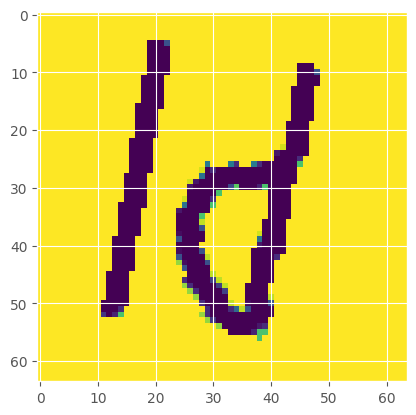

DBG: Img class:6


In [38]:
instruments.show_img(X_train[0, 0, :, :])
instruments.debug(f'Img class:{y_train[0]}')

## Структура сверточной сети

In [39]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = 2
        self.linear_layers = 3

        # Convolution layers
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=14, kernel_size=5, padding=0)  # 64 -> 60
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)       # 60 -> 30

        self.conv2 = torch.nn.Conv2d(
            in_channels=14, out_channels=18, kernel_size=5, padding=0)  # 30 -> 26
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)        # 26 -> 13

        # Linear layers
        self.fc1 = torch.nn.Linear(13 * 13 * 18, 512)
        self.act3 = torch.nn.Sigmoid()

        self.fc2 = torch.nn.Linear(512, 200)
        self.act4 = torch.nn.Sigmoid()

        self.fc3 = torch.nn.Linear(200, 10)

    def forward(self, x):
        # Convolution layers
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # Linear layers
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

In [40]:
# Prepare neuralnetwork
my_neuralnet = CNN()

Выберем устройство на котором будут происходить вычисления.

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_neuralnet = my_neuralnet.to(device)

## Обучение сверточной сети

Инициализируем необходимые параметры:

In [42]:
# Educate network
optimizer = torch.optim.Adam(my_neuralnet.parameters(), lr=constants.LR)
test_accuracy_metrics = []
test_loss_metrics = []
f1_score_metrics = []

Начинаем процесс обучения:

In [43]:

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(constants.NUM_EPOCH):
    order = np.random.permutation(len(X_train))
    # Start education
    for start_index in range(0, len(X_train), constants.BATCH_SIZE):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + constants.BATCH_SIZE]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        predict_res = my_neuralnet.forward(X_batch)

        loss_value = torch.nn.CrossEntropyLoss()(predict_res, y_batch)
        loss_value.backward()

        optimizer.step()

    # Check epoch result and save metrics
    test_predict_res = my_neuralnet.forward(X_test)
    test_loss_metrics.append(torch.nn.CrossEntropyLoss()(test_predict_res, y_test).data.cpu())

    accuracy = (test_predict_res.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_metrics.append(accuracy)

    f1 = f1_score(y_test, test_predict_res.argmax(dim=1).numpy(), average='weighted')
    f1_score_metrics.append(f1)

    instruments.debug(f'Epoch {epoch}: accuracy:{accuracy}, F1 score:{f1}')

DBG: Epoch 0: accuracy:0.45728641748428345, F1 score:0.37043562074805253
DBG: Epoch 1: accuracy:0.8693467378616333, F1 score:0.8340566136450106
DBG: Epoch 2: accuracy:0.7587939500808716, F1 score:0.7777348898395307
DBG: Epoch 3: accuracy:0.9899497628211975, F1 score:0.9899586784499151
DBG: Epoch 4: accuracy:1.0, F1 score:1.0
DBG: Epoch 5: accuracy:1.0, F1 score:1.0
DBG: Epoch 6: accuracy:1.0, F1 score:1.0
DBG: Epoch 7: accuracy:1.0, F1 score:1.0
DBG: Epoch 8: accuracy:1.0, F1 score:1.0
DBG: Epoch 9: accuracy:1.0, F1 score:1.0
DBG: Epoch 10: accuracy:1.0, F1 score:1.0
DBG: Epoch 11: accuracy:1.0, F1 score:1.0
DBG: Epoch 12: accuracy:1.0, F1 score:1.0
DBG: Epoch 13: accuracy:1.0, F1 score:1.0
DBG: Epoch 14: accuracy:1.0, F1 score:1.0
DBG: Epoch 15: accuracy:1.0, F1 score:1.0
DBG: Epoch 16: accuracy:1.0, F1 score:1.0
DBG: Epoch 17: accuracy:1.0, F1 score:1.0
DBG: Epoch 18: accuracy:1.0, F1 score:1.0
DBG: Epoch 19: accuracy:1.0, F1 score:1.0


## Полученные метрики

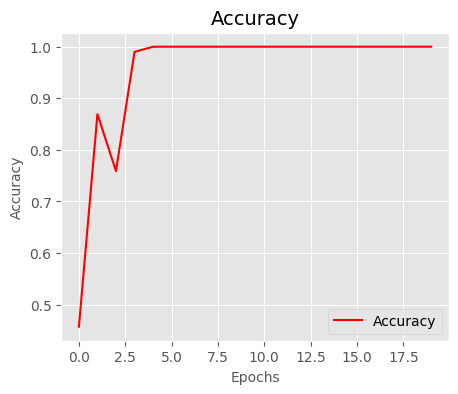

In [44]:
instruments.plot_metric(test_accuracy_metrics, 'Accuracy', 'Accuracy')

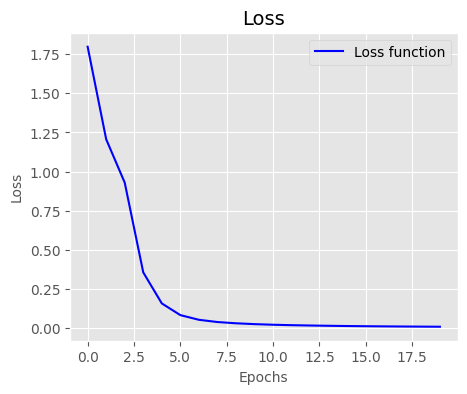

In [45]:
instruments.plot_metric(test_loss_metrics, 'Loss function', 'Loss', color='blue')

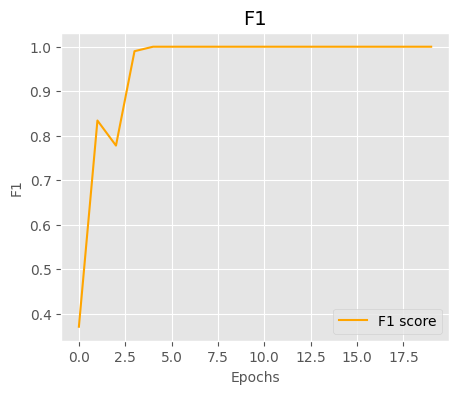

In [46]:
instruments.plot_metric(f1_score_metrics, 'F1 score', 'F1', color='orange')